# Link your google drive
Put **helper.py** and **celeba.zip** under the same directory. We'll extract celeba.zip to `./data/`.

In [0]:
# Mount google drive at '/gdrive'.
from google.colab import drive
drive.mount('/gdrive')
# Move helper.py and celeba.zip to the workspace.
! mkdir data
! unzip -q /gdrive/'My Drive'/'DLCV Homework'/'HW02'/celeba.zip -d ./data/
! cp /gdrive/'My Drive'/'DLCV Homework'/'HW02'/helper.py ./
! mkdir Results

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Homework2 Face Generation
In HW2, You'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using CelebA datasets in this homework, we provide the code for you to download the dataset and preprocess data

In [0]:
import os
import helper
import matplotlib.pyplot as plt
from glob import glob

# Main
All works I've done are in this section.
## Include packages

In [0]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = random.randint(1, 10000)
# manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)

## Set all parameters
The input/output size and all hyperparameters are decided here.

In [0]:
# Root directory for dataset
dataroot = "./data"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 60

# Learning rate for optimizers
lr = 0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Load the face data

torch.Size([3, 64, 64])


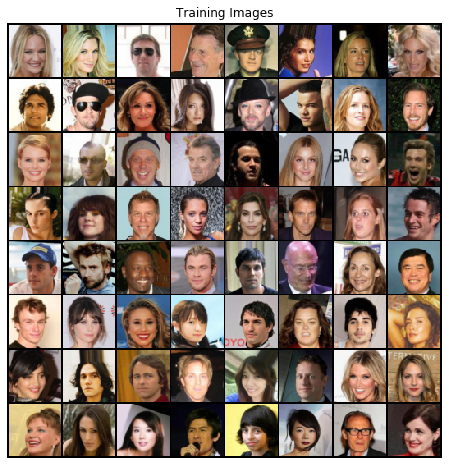

In [0]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch[0][0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1,2,0)
    )
)

## Build the generator

In [0]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Create generator instance and initialize the weight

In [0]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Build the discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        output = self.main(input)
        output = output.mean(0)
        return output.view(1)

## Create discriminator instance and initialize the weight

In [0]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


## Loss function and optimizer

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = torch.FloatTensor([1])
fake_label = real_label * -1
real_label = real_label.cuda()
fake_label = fake_label.cuda()

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

## Load the trained model to train it deeper

In [0]:
! cp /gdrive/'My Drive'/'DLCV Homework'/'HW02'/'Parameters'/\
'WGAN'/checkpoint_116.pth ./

retrain = True
if retrain:
    checkpoint = torch.load('./checkpoint_116.pth')
    now_epoch = checkpoint['epoch'] + 1
    netG.load_state_dict(checkpoint['netG'])
    netD.load_state_dict(checkpoint['netD'])
    optimizerG.load_state_dict(checkpoint['optimG'])
    optimizerD.load_state_dict(checkpoint['optimD'])
    G_losses = checkpoint['lossG']
    D_losses = checkpoint['lossD']
    img_list = [checkpoint['img_list']]
    gen_iters = checkpoint['gen_iters']
else:
    now_epoch = 0
    G_losses = []
    D_losses = []
    img_list = []
    gen_iters = 0

## Train the model

In [0]:
# Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(now_epoch, 120):
    # For each batch in the dataloader
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        ############################
        # (1) Update D network
        ###########################
        # Reset requires_grad. They are set to False below in netG update.
        for p in netD.parameters():
            p.requires_grad = True

        # Train the discriminator Diters times.
        if gen_iters < 25 or gen_iters%500 == 0:
            iter_D = 100
        else:
            iter_D = 5

        j = 0
        while j < iter_D and i < len(dataloader):
            j += 1

            # Clamp parameters to a cube.
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            data = data_iter.next()
            i += 1

            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            # Forward pass real batch through D
            errD_real = netD(real_cpu)
            errD_real.backward(real_label)

            ## Train with all-fake batch
            # Generate fake image batch with G
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            # Calculate D's loss on the all-fake batch
            errD_fake = netD(fake.detach())
            errD_fake.backward(fake_label)
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real - errD_fake
            # Update D
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False
        netG.zero_grad()
        # Generate fake image batch with G
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        # Calculate G's loss based on this output
        errG = netD(fake)
        # Calculate gradients for G
        errG.backward(real_label)
        # Update G
        optimizerG.step()
        gen_iters += 1

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_D_real: %.4f\tLoss_D_fake: %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), errD_real.item(), errD_fake.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (gen_iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Save result.
    path = './checkpoint_' + str(epoch) + '.pth'
    torch.save({
        'epoch': epoch,
        'gen_iters': gen_iters,
        'netG': netG.state_dict(),
        'netD': netD.state_dict(),
        'optimG': optimizerG.state_dict(),
        'optimD': optimizerD.state_dict(),
        'lossG': G_losses,
        'lossD': D_losses,
        'img_list': img_list[-1]
    }, path)

    # Move it to my google drive.
    drive.mount('/gdrive')
    ! mv {path} /gdrive/'My Drive'/'DLCV Homework'/'HW02'/'Parameters'/'WGAN'

Starting Training Loop...
[61/60][50/3166]	Loss_D: -0.3368	Loss_G: 0.3049	Loss_D_real: -0.2596	Loss_D_fake: 0.0772
[61/60][100/3166]	Loss_D: -0.2020	Loss_G: 0.3714	Loss_D_real: -0.4072	Loss_D_fake: -0.2052
[61/60][150/3166]	Loss_D: -0.2139	Loss_G: 0.0242	Loss_D_real: 0.0094	Loss_D_fake: 0.2233
[61/60][200/3166]	Loss_D: -0.2961	Loss_G: -0.1470	Loss_D_real: -0.0395	Loss_D_fake: 0.2566
[61/60][250/3166]	Loss_D: -0.2321	Loss_G: -0.1021	Loss_D_real: -0.0027	Loss_D_fake: 0.2294
[61/60][300/3166]	Loss_D: -0.2324	Loss_G: 0.3692	Loss_D_real: -0.3738	Loss_D_fake: -0.1414
[61/60][350/3166]	Loss_D: -0.2630	Loss_G: 0.2341	Loss_D_real: -0.2497	Loss_D_fake: 0.0133
[61/60][400/3166]	Loss_D: -0.3187	Loss_G: -0.0316	Loss_D_real: -0.0768	Loss_D_fake: 0.2419
[61/60][450/3166]	Loss_D: -0.3191	Loss_G: -0.0379	Loss_D_real: -0.0630	Loss_D_fake: 0.2561
[61/60][500/3166]	Loss_D: -0.2965	Loss_G: 0.0936	Loss_D_real: -0.1713	Loss_D_fake: 0.1253
[61/60][550/3166]	Loss_D: -0.3015	Loss_G: 0.2252	Loss_D_real: -0.1251	

## Testing
Load the parameters to a new generator.

In [0]:
# Copy the parameters file to the work space.
! cp /gdrive/'My Drive'/'DLCV Homework'/'HW02'/'Parameters'/\
'WGAN'/checkpoint_36.pth ./

checkpoint = torch.load('./checkpoint_36.pth')
fake_face_generator = Generator(ngpu).to(device)
fake_face_generator.load_state_dict(checkpoint['netG'])
G_losses = checkpoint['lossG']
D_losses = checkpoint['lossD']
img_list = [checkpoint['img_list']]

## Result
A plot of D & G’s losses versus training iterations.

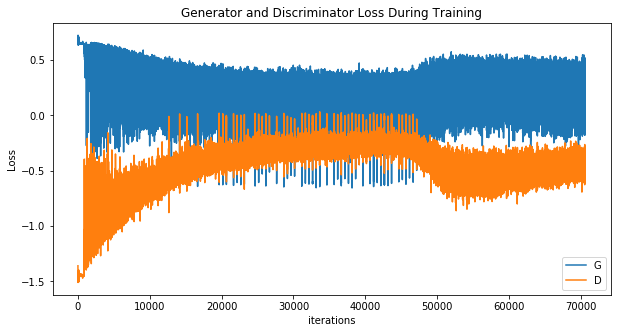

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Real image v.s. fake image.

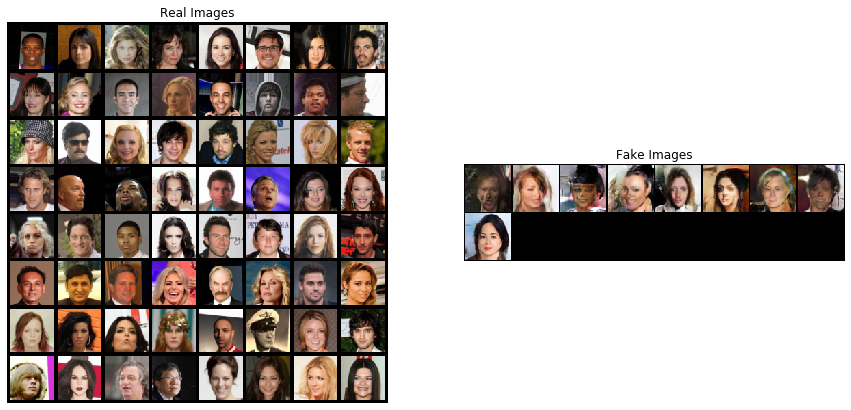

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# You must use "output_fig" function to save your array of images into figure!
# Submit your results.png to google drive

In [0]:
def output_fig(images_array, file_name="./results"):
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(helper.images_square_grid(images_array))
    plt.axis("off")
    plt.savefig(file_name+'.png', bbox_inches='tight', pad_inches=0)    

## Pseudo code for you

(9, 64, 64, 3)


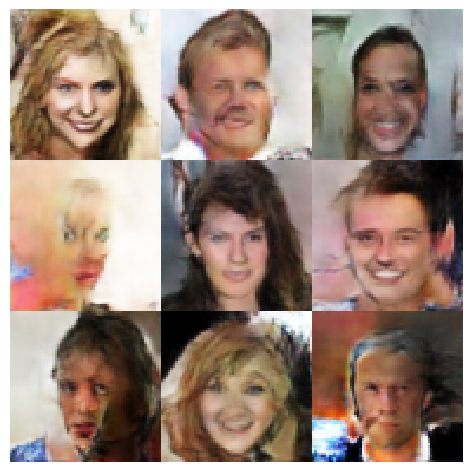

In [0]:
fixed_noise = torch.randn(9, nz, 1, 1, device=device)
with torch.no_grad():
    generated_images = np.array([
        np.transpose(img, (1,2,0))
        for img in fake_face_generator(fixed_noise).detach().cpu().numpy()
    ])
print(generated_images.shape) # should be (9, width, height, 3)
output_fig(generated_images, file_name="./Results/{}_image".format(str.zfill(str(i), 3)))

Store the output images to my google drive.

In [0]:
drive.mount('/gdrive')
! cp ./Results/* /gdrive/'My Drive'/'DLCV Homework'/'HW02'/'Results'/